In [1]:
import ee, datetime    # Google Earth Engine
import folium
import matplotlib.pyplot as plt
import numpy as np
import geehydro
from datetime import datetime as dt
from IPython.display import Image

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWiGsn2Mg_qnEySvrN0Y_V_wxuPzUO0D6hIa7Mrk0xGiSGe1r8OXxMI

Successfully saved authorization token.


### Selecteer regio  

Hierbij zullen we Nederland coördinaten definiëren.  

In [44]:
area_of_interest = ee.Geometry.Rectangle([3.4, 50.5, 7.5, 53.6]) #NL AOI


### Dataset importeren 

Sentinel-2 is een brede multispectrale beeldvormingsmissie met hoge resolutie die Copernicus Land Monitoring-onderzoeken ondersteunt, waaronder de monitoring van vegetatie, bodem en waterbedekking, evenals observatie van binnenwateren en kustgebieden.

In [60]:

sr_coll = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2021-06-01', '2021-09-19') #Select periode 
landsat_AOI = sr_coll.filterBounds(area_of_interest)
sr_coll = sr_coll.min().slice(0,9) #data slice


 ### Data visualization  
 Voeg Earth Engine-tekenmethode toe aan folium.


In [62]:
vis = {
    'bands': ['B6', 'B5', 'B2'],
    'min': 0,
    'max': 0.5,
    'gamma': [0.95, 1.1, 1],
    'region':area_of_interest} 

image = sr_coll.clip(area_of_interest)


mapid = image.getMapId(vis)

map = folium.Map(location=[52.5,5.5],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2 ',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Calculate Grenneess methodes 

#### 1. NDVI (Normalized Difference Vegetation Index)
    
NDVI van elke afbeeldingspixel in de afbeeldingen wordt berekend met de vergelijking:

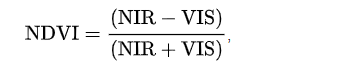 
 

Waarbij NIR de B5-band is en Rood de B4-band. De gemiddelde NDVI wordt berekend op elke afbeelding om een tijdreeks-NDVI van de AOI te krijgen.

NDVI-berekening

In [6]:
def NDVI(image):
    return image.normalizedDifference(['B5', 'B4'])

#### 2. SAM (Spectral Angle Mapper)
Het Spectral Angle Mapper (SAM)-algoritme is gebaseerd op een ideale aanname dat een enkele pixel van een remote sensing-beeld één bepaald bodembedekkingsmateriaal vertegenwoordigt en op unieke wijze kan worden toegewezen aan slechts één bodembedekkingsklasse.

In [7]:
def SAM(image):
    band1 = image.select("B1")
    bandn = image.select("B2","B3","B4","B5","B6","B7","B8","B9");
    maxObjSize = 256;
    b = band1.divide(bandn);
    spectralAngleMap = b.atan();
    spectralAngleMap_sin = spectralAngleMap.sin();
    spectralAngleMap_cos = spectralAngleMap.cos();
    sum_cos = spectralAngleMap_cos.reduce(ee.call("Reducer.sum"));
    sum_sin = spectralAngleMap_sin.reduce(ee.call("Reducer.sum"));
    return ee.Image.cat(sum_sin, sum_cos, spectralAngleMap_sin, spectralAngleMap_cos);

#### 3. EVI (Enhanced vegetation index)
 Enhanced vegetation index is een 'geoptimaliseerde' vegetatie-index die is ontworpen om het vegetatiesignaal te verbeteren met verbeterde gevoeligheid in gebieden met een hoge biomassa en verbeterde vegetatiemonitoring door een ontkoppeling van het kruinachtergrondsignaal en een vermindering van atmosfeerinvloeden. EVI wordt berekend volgens deze vergelijking: 
    
    
   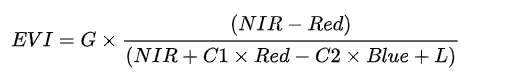

In [8]:
def EVI(image):
    # L(Canopy background)
    # C1,C2(Coefficients of aerosol resistance term)
    # GainFactor(Gain or scaling factor)
    gain_factor = ee.Image(2.5);
    coefficient_1 = ee.Image(6);
    coefficient_2 = ee.Image(7.5);
    l = ee.Image(1);
    nir = image.select("B5");
    red = image.select("B4");
    blue = image.select("B2");
    evi = image.expression(
        "Gain_Factor*((NIR-RED)/(NIR+C1*RED-C2*BLUE+L))",
        {
            "Gain_Factor":gain_factor,
            "NIR":nir,
            "RED":red,
            "C1":coefficient_1,
            "C2":coefficient_2,
            "BLUE":blue,
            "L":l
        }
    )
    return evi

#### 4.ARVI (Atmospherically Resistant Vegetation Index)

ARVI is het meest bruikbaar in gebieden met een hoog atmosferisch aërosolgehalte. Het gebruikt blauwlichtreflectiemetingen om de atmosferische verstrooiingseffecten te corrigeren, die ook de reflectie van rood licht beïnvloeden.

Algemene formule:


    (NIR - RED - y * (RED - BLUE))/ (NIR + RED - y*(RED-BLUE))

In [9]:
def ARVI(image):
    red = image.select("B4")
    blue = image.select("B2")
    nir = image.select("B5")
    red_square = red.multiply(red)
    arvi = image.expression(
        "NIR - (REDsq - BLUE)/(NIR+(REDsq-BLUE))",{
            "NIR": nir,
            "REDsq": red_square,
            "BLUE": blue
        }
    )
    return arvi

#### 5.LAI (Leaf area index)
Leaf area index (LAI) is een maat voor de ontwikkeling van het bladerdak op een bepaald moment. Het kan worden gekwantificeerd met de formule: 

                 Leaf area (m2)/Ground cover (m2).



In [10]:
def LAI(image):
    nir = image.select("B5")
    red = image.select("B4")
    coeff1 = ee.Image(0.0305);
    coeff2 = ee.Image(1.2640);
    lai = image.expression(
        "(((NIR/RED)*COEFF1)+COEFF2)",
        {
            "NIR":nir,
            "RED":red,
            "COEFF1":coeff1,
            "COEFF2":coeff2
        }
    )
    return lai

#### 6. Tasseled Cap Transformation   
Een methode om de spectrale informatie van satellietgegevens om te zetten in spectrale indicatoren. Deze index wordt vooral gebruikt bij de analyse van vegetatie. 


Zes van de zeven satellite TM-banden worden gebruikt voor het algoritme, waardoor drie informatieniveaus worden gegenereerd:

Tasseled Cap Band 1 (helderheid, een meetwaarde voor de grond)
Tasseled Cap Band 2 (groenheid, een meetwaarde voor de vegetatie)
Tasseled Cap Band 3 (natheid, een gemeten waarde voor interacties van bodem- en bladervochtigheid)
Het algoritme voor deze drie informatieniveaus is een gewogen som van de Landsat-banden (zonder het thermische kanaal 6), waarbij elke band wordt vermenigvuldigd met de specifieke coëfficiënten:

* Helderheid = 0,3037 (band 1) + 0,2793 (band 2) + 0,4743 (band 3) + 0,5585 (band 4) + 0,5082 (band 5) + 0,1863 (band 7)*
* Groenheid = −0,2848 (band 1) − 0,2435 (band 2) − 0,5436 (band 3) + 0,7243 (band 4) + 0,0840 (band 5) − 0,1800 (band 7)
* Natheid = 0,1509 (band 1) + 0,1973 (band 2) + 0,3279 (band 3) + 0,3406 (band 4) − 0,7112 (band 5) − 0,4572 (band 7)

In [11]:
def tasseled_cap_transformation(image):
    #Tasseled Cap Transformation for satellite based on the 
    #scientfic work "Derivation of a tasselled cap transformation based on satellite reflectance" 

    b = image.select("B2", "B3", "B4", "B5", "B6", "B7");
    #Coefficients are only for satellite TOA
    brightness_coefficents= ee.Image([0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872])
    greenness_coefficents= ee.Image([-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608]);
    wetness_coefficents= ee.Image([0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559]);
    fourth_coefficents= ee.Image([-0.8239, 0.0849, 0.4396, -0.058, 0.2013, -0.2773]);
    fifth_coefficents= ee.Image([-0.3294, 0.0557, 0.1056, 0.1855, -0.4349, 0.8085]);
    sixth_coefficents= ee.Image([0.1079, -0.9023, 0.4119, 0.0575, -0.0259, 0.0252]);
    
    #Calculate tasseled cap transformation
    brightness = image.expression(
        '(B * BRIGHTNESS)',
        {
            'B':b,
            'BRIGHTNESS': brightness_coefficents
        })
    greenness = image.expression(
        '(B * GREENNESS)',
        {
            'B':b,
            'GREENNESS': greenness_coefficents
        })
    wetness = image.expression(
        '(B * WETNESS)',
        {
            'B':b,
            'WETNESS': wetness_coefficents
        })
    fourth = image.expression(
        '(B * FOURTH)',
        {
            'B':b,
            'FOURTH': fourth_coefficents
        })
    fifth = image.expression(
        '(B * FIFTH)',
        {
            'B':b,
            'FIFTH': fifth_coefficents
        })
    sixth = image.expression(
        '(B * SIXTH)',
        {
            'B':b,
            'SIXTH': sixth_coefficents
        })
    bright = brightness.reduce(ee.call("Reducer.sum"));
    green = greenness.reduce(ee.call("Reducer.sum"));
    wet = wetness.reduce(ee.call("Reducer.sum"));
    four = fourth.reduce(ee.call("Reducer.sum"));
    five = fifth.reduce(ee.call("Reducer.sum"));
    six = sixth.reduce(ee.call("Reducer.sum"));
    tasseled_cap = ee.Image(bright).addBands(green).addBands(wet).addBands(four).addBands(five).addBands(six)
    return tasseled_cap.rename('brightness','greenness','wetness','fourth','fifth','sixth')

### Tasseled Cap Transformation 
We zullen hieronder Tasseled cap transformation gebruiken om vegetation te berekenen, 

In [12]:
tct = tasseled_cap_transformation(sr_coll)


In [13]:
# plot tct !! 

image = tct.clip(area_of_interest)

vis_tct = {'min':-1,'max':2,'size':'800',
          'bands':['brightness','greenness','wetness'],
          'region':area_of_interest}


mapid = image.getMapId(vis_tct)

map = folium.Map(location=[52.5,5.5],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Tasseled Cap Transformation',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Band 2 (Grennees) in tct 

TCT levert 3 band informatie zoals boven genoemd werd. We zijn geintresseert in band 2 (grennees)

In [14]:
palette = ['FFFFFF','C0C0C0','808080','000000','FF0000','800000','FFFF00','808000','00FF00','008000','00FFFF','008080','0000FF','000080','FF00FF','800080']
palette = ','.join(palette)

In [15]:
image = tct.clip(area_of_interest)

vis_tct = {'min':-1,'max':2,'size':'800',
           'bands':['greenness'],
           'palette':['ffffe5','f7fcb9','d9f0a3','addd8e','78c679','41ab5d','238443','006837','004529'],
           'region':area_of_interest}

mapid = image.getMapId(vis_tct)

map = folium.Map(location=[52.5,5.5],zoom_start=8, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Tasseled Cap Transformation Greenness',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Export Data to Google Drive file 

In [71]:
# task = ee.batch.Export.image.toDrive(**{
# 'image': tct.clip(area_of_interest),
# 'description': 'tct',
# 'folder':'test',
# 'scale':120,
# 'region': area_of_interest ,
# 'crs':'EPSG:4326',
# 'fileFormat':'GeoTIFF',
# })
# task.start()

In [70]:
# import time 
# while task.active():
    
#       print('Polling for task (id: {}).'.format(task.id))
#       time.sleep(5)

### NDVI 

In [18]:
ndvi = NDVI(sr_coll)

In [19]:
image = ndvi.clip(area_of_interest)

vis_ndvi = {'min':-3,'max':3,'size':'800',
            'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901','66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01','012E01', '011D01', '011301'],
        
           'region':area_of_interest}

mapid = image.getMapId(vis_ndvi)

map = folium.Map(location=[52.5,5.5],zoom_start=9, height=500,width=700)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='NDVI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Export Data to Google Drive file

In [26]:
# task = ee.batch.Export.image.toDrive(**{
# 'image': ndvi,
# 'description': 'ndvi',
# 'folder':'test',
# 'scale':120,
# 'region': area_of_interest ,
# 'crs':'EPSG:4326',
# 'fileFormat':'GeoTIFF',
# })
# task.start()

In [27]:
# import time 
# while task.active():
    
#       print('Polling for task (id: {}).'.format(task.id))
#       time.sleep(5)

In [33]:
import pandas as pd

import seaborn as sns

### QGIS results

In [75]:
ndvi_citys_values = pd.read_csv('NDVI_gemeenten.csv')
ndvi_citys_values.rename(columns = {'gemeentenaam':'RegioS', '_NDVImean':'NDVI'}, inplace = True)

ndvi_citys_values

,fid,gemeentecode,RegioS,water,omgevingsadressendichtheid,stedelijkheidAdressenPerKm2,bevolkingsdichtheidInwonersPerKm2,aantalInwoners,mannen,vrouwen,...,percentageOverigeNietwestersemigratieachtergrond,oppervlakteTotaalInHa,oppervlakteLandInHa,oppervlakteWaterInHa,jaarstatcode,jaar,fuuid,_NDVIcount,_NDVIsum,NDVI
0,1,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,9,19796,18560,1236,2021GM0014,2021,gemeenten2021.da78b6c2-9c4c-4644-b4c6-9a7d9bd4...,22915,7960.485257,0.347392
1,2,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,16,24877,12919,11958,2021GM0034,2021,gemeenten2021.560f08ed-061e-4424-87bd-e3a7ac2e...,15804,4127.984745,0.261199
2,3,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,3,11994,11764,230,2021GM0037,2021,gemeenten2021.5ec518c5-c8be-4f1d-bb6e-2050ab78...,13814,5239.211469,0.379268
3,4,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,4,7868,7600,268,2021GM0047,2021,gemeenten2021.41109a23-fa5f-427c-a59c-ca966935...,9081,3486.651387,0.383950
4,5,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,4,26886,24723,2163,2021GM0050,2021,gemeenten2021.38219389-9b0c-443e-95e3-764e2733...,28667,11329.215761,0.395201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,348,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,3,90308,48249,42059,2021GM1966,2021,gemeenten2021.b2d10535-e2ad-456c-a022-11ff1171...,56671,22449.526773,0.396138
348,349,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,3,36887,36269,618,2021GM1969,2021,gemeenten2021.2f827ba7-ee78-418e-9942-e2fa8174...,42693,17834.593992,0.417740
349,350,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2,51645,37783,13862,2021GM1970,2021,gemeenten2021.94232bff-958b-4242-a225-66082c2a...,44537,19576.225526,0.439550
350,351,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2,19158,18173,986,2021GM1978,2021,gemeenten2021.72ca78b8-28e6-4ac3-b925-5e3350a2...,21514,8330.280452,0.387203


In [35]:
ndvi_citys_values

,fid,gemeentecode,gemeentenaam,water,omgevingsadressendichtheid,stedelijkheidAdressenPerKm2,bevolkingsdichtheidInwonersPerKm2,aantalInwoners,mannen,vrouwen,...,percentageOverigeNietwestersemigratieachtergrond,oppervlakteTotaalInHa,oppervlakteLandInHa,oppervlakteWaterInHa,jaarstatcode,jaar,fuuid,_NDVIcount,_NDVIsum,_NDVImean
0,1,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,9,19796,18560,1236,2021GM0014,2021,gemeenten2021.da78b6c2-9c4c-4644-b4c6-9a7d9bd4...,22915,7960.485257,0.347392
1,2,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,16,24877,12919,11958,2021GM0034,2021,gemeenten2021.560f08ed-061e-4424-87bd-e3a7ac2e...,15804,4127.984745,0.261199
2,3,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,3,11994,11764,230,2021GM0037,2021,gemeenten2021.5ec518c5-c8be-4f1d-bb6e-2050ab78...,13814,5239.211469,0.379268
3,4,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,4,7868,7600,268,2021GM0047,2021,gemeenten2021.41109a23-fa5f-427c-a59c-ca966935...,9081,3486.651387,0.383950
4,5,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,4,26886,24723,2163,2021GM0050,2021,gemeenten2021.38219389-9b0c-443e-95e3-764e2733...,28667,11329.215761,0.395201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,348,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,3,90308,48249,42059,2021GM1966,2021,gemeenten2021.b2d10535-e2ad-456c-a022-11ff1171...,56671,22449.526773,0.396138
348,349,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,3,36887,36269,618,2021GM1969,2021,gemeenten2021.2f827ba7-ee78-418e-9942-e2fa8174...,42693,17834.593992,0.417740
349,350,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2,51645,37783,13862,2021GM1970,2021,gemeenten2021.94232bff-958b-4242-a225-66082c2a...,44537,19576.225526,0.439550
350,351,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2,19158,18173,986,2021GM1978,2021,gemeenten2021.72ca78b8-28e6-4ac3-b925-5e3350a2...,21514,8330.280452,0.387203


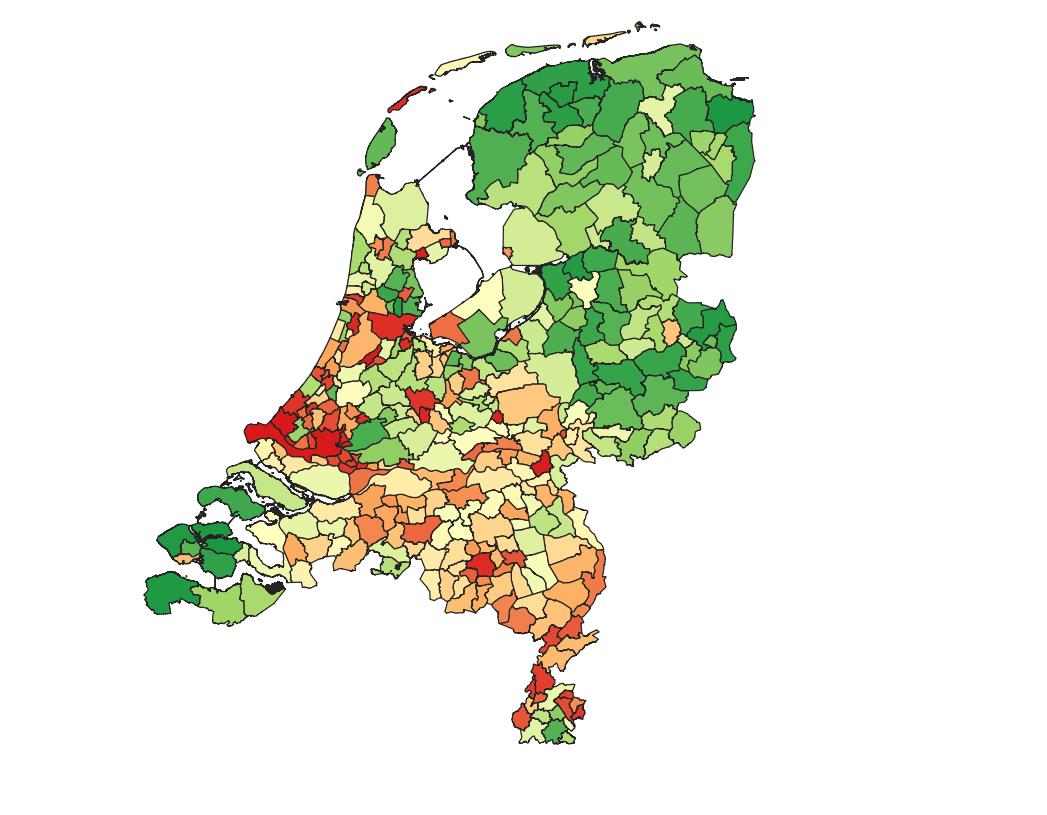

In [39]:
from IPython.display import Image
Image(filename='test/NDVI1.png')

In [74]:
tasseldcap_citys_values = pd.read_csv('Tasseld_cap_gemeenten_greenness.csv')
tasseldcap_citys_values.rename(columns = {'gemeentenaam':'RegioS'}, inplace = True)

tasseldcap_citys_values

,fid,gemeentecode,RegioS,water,omgevingsadressendichtheid,stedelijkheidAdressenPerKm2,bevolkingsdichtheidInwonersPerKm2,aantalInwoners,mannen,vrouwen,...,percentageOverigeNietwestersemigratieachtergrond,oppervlakteTotaalInHa,oppervlakteLandInHa,oppervlakteWaterInHa,jaarstatcode,jaar,fuuid,Greenesscount,Greenesssum,Greenessmean
0,1,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,9,19796,18560,1236,2021GM0014,2021,gemeenten2021.da78b6c2-9c4c-4644-b4c6-9a7d9bd4...,22915,-1.558139e+06,-67.996481
1,2,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,16,24877,12919,11958,2021GM0034,2021,gemeenten2021.560f08ed-061e-4424-87bd-e3a7ac2e...,15804,-2.115321e+06,-133.847165
2,3,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,3,11994,11764,230,2021GM0037,2021,gemeenten2021.5ec518c5-c8be-4f1d-bb6e-2050ab78...,13814,-7.546212e+05,-54.627280
3,4,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,4,7868,7600,268,2021GM0047,2021,gemeenten2021.41109a23-fa5f-427c-a59c-ca966935...,9081,-4.271031e+05,-47.032611
4,5,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,4,26886,24723,2163,2021GM0050,2021,gemeenten2021.38219389-9b0c-443e-95e3-764e2733...,28667,-1.859006e+06,-64.848299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,348,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,3,90308,48249,42059,2021GM1966,2021,gemeenten2021.b2d10535-e2ad-456c-a022-11ff1171...,56671,-3.215110e+06,-56.732905
348,349,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,3,36887,36269,618,2021GM1969,2021,gemeenten2021.2f827ba7-ee78-418e-9942-e2fa8174...,42693,-2.045376e+06,-47.908937
349,350,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2,51645,37783,13862,2021GM1970,2021,gemeenten2021.94232bff-958b-4242-a225-66082c2a...,44537,-1.561696e+06,-35.065128
350,351,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2,19158,18173,986,2021GM1978,2021,gemeenten2021.72ca78b8-28e6-4ac3-b925-5e3350a2...,21514,-1.502163e+06,-69.822567


In [37]:
tasseldcap_citys_values

,fid,gemeentecode,gemeentenaam,water,omgevingsadressendichtheid,stedelijkheidAdressenPerKm2,bevolkingsdichtheidInwonersPerKm2,aantalInwoners,mannen,vrouwen,...,percentageOverigeNietwestersemigratieachtergrond,oppervlakteTotaalInHa,oppervlakteLandInHa,oppervlakteWaterInHa,jaarstatcode,jaar,fuuid,Greenesscount,Greenesssum,Greenessmean
0,1,GM0014,Groningen,NEE,3312,1,1257,233273,116177,117096,...,9,19796,18560,1236,2021GM0014,2021,gemeenten2021.da78b6c2-9c4c-4644-b4c6-9a7d9bd4...,22915,-1.558139e+06,-67.996481
1,2,GM0034,Almere,NEE,1616,2,1662,214715,106523,108192,...,16,24877,12919,11958,2021GM0034,2021,gemeenten2021.560f08ed-061e-4424-87bd-e3a7ac2e...,15804,-2.115321e+06,-133.847165
2,3,GM0037,Stadskanaal,NEE,836,4,270,31754,15659,16095,...,3,11994,11764,230,2021GM0037,2021,gemeenten2021.5ec518c5-c8be-4f1d-bb6e-2050ab78...,13814,-7.546212e+05,-54.627280
3,4,GM0047,Veendam,NEE,1007,3,361,27417,13700,13717,...,4,7868,7600,268,2021GM0047,2021,gemeenten2021.41109a23-fa5f-427c-a59c-ca966935...,9081,-4.271031e+05,-47.032611
4,5,GM0050,Zeewolde,NEE,822,4,93,22879,11662,11217,...,4,26886,24723,2163,2021GM0050,2021,gemeenten2021.38219389-9b0c-443e-95e3-764e2733...,28667,-1.859006e+06,-64.848299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,348,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,...,3,90308,48249,42059,2021GM1966,2021,gemeenten2021.b2d10535-e2ad-456c-a022-11ff1171...,56671,-3.215110e+06,-56.732905
348,349,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,...,3,36887,36269,618,2021GM1969,2021,gemeenten2021.2f827ba7-ee78-418e-9942-e2fa8174...,42693,-2.045376e+06,-47.908937
349,350,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,...,2,51645,37783,13862,2021GM1970,2021,gemeenten2021.94232bff-958b-4242-a225-66082c2a...,44537,-1.561696e+06,-35.065128
350,351,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,...,2,19158,18173,986,2021GM1978,2021,gemeenten2021.72ca78b8-28e6-4ac3-b925-5e3350a2...,21514,-1.502163e+06,-69.822567


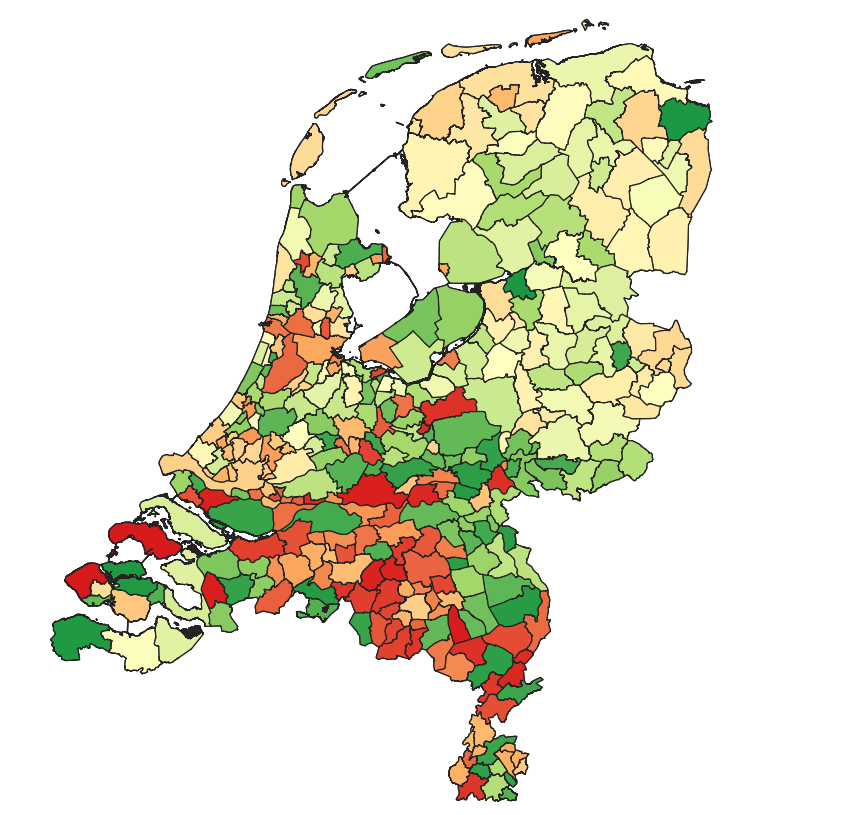

In [40]:
from IPython.display import Image
Image(filename='test/Tasseld_cap1.png')

### CBS Data 


In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cbsodata 
import geopandas as gpd

In [83]:
# Downloading table list
# Downloading entire dataset (can take up to 30s)
toc = pd.DataFrame(cbsodata.get_table_list())

#Gezonhied monitoren
gezondhied_df = pd.DataFrame(cbsodata.get_data('85012NED'))

boedem_df = pd.DataFrame(cbsodata.get_data('70262ned'))

In [84]:
boedem_df = boedem_df[['RegioS','Perioden','Spoorterrein_3','OpenNatNatuurlijkTerrein_31','Bos_29','TotaalBosEnOpenNatuurlijkTerrein_28','OpenDroogNatuurlijkTerrein_30']].replace(True)
boedem_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)
boedem_df.dropna(inplace = True)

In [85]:
obesitas_df = gezondhied_df[['RegioS','Ondergewicht_7','NormaalGewicht_8','MatigOvergewicht_10','Overgewicht_9','ErnstigOvergewichtObesitas_11']]
obesitas_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)
obesitas_df = obesitas_df.merge(boedem_df, on = 'RegioS', how = 'outer')
obesitas_df.dropna(inplace = True)
obesitas_df

C:\Users\hasso\AppData\Local\Temp\ipykernel_21852\3168193462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesitas_df.drop_duplicates(subset = 'RegioS', keep = 'last',inplace = True)


,RegioS,Ondergewicht_7,NormaalGewicht_8,MatigOvergewicht_10,Overgewicht_9,ErnstigOvergewichtObesitas_11,Perioden,Spoorterrein_3,OpenNatNatuurlijkTerrein_31,Bos_29,TotaalBosEnOpenNatuurlijkTerrein_28,OpenDroogNatuurlijkTerrein_30
0,Nederland,1.2,40.6,41.5,58.8,17.5,2015,8885.0,62631.0,341270.0,498956.0,95055.0
1,Noord-Nederland (LD),1.2,40.6,43.1,60.0,17.6,2015,1121.0,24910.0,50292.0,103062.0,27861.0
2,Oost-Nederland (LD),1.1,39.8,42.2,60.3,18.5,2015,2274.0,13186.0,144799.0,185016.0,27032.0
3,West-Nederland (LD),1.3,42.1,40.8,57.5,17.0,2015,3765.0,16755.0,43368.0,89614.0,29491.0
4,Zuid-Nederland (LD),1.1,39.4,42.7,60.4,18.1,2015,1725.0,7780.0,102811.0,121263.0,10671.0
...,...,...,...,...,...,...,...,...,...,...,...,...
367,Zundert,3.2,44.4,47.9,64.4,21.1,2015,0.0,179.0,1200.0,1586.0,208.0
368,Zutphen,2.3,47.4,44.6,60.3,19.4,2015,33.0,42.0,579.0,623.0,4.0
369,Zwartewaterland,1.8,37.0,50.7,70.7,24.1,2015,0.0,339.0,127.0,501.0,35.0
370,Zwijndrecht,2.4,40.1,49.3,67.0,21.6,2015,120.0,23.0,45.0,68.0,0.0


In [86]:
NDVI_df = ndvi_citys_values[['gemeentecode','RegioS','NDVI']]

In [87]:
obesitas_df = obesitas_df.merge(NDVI_df, on = 'RegioS', how = 'outer')
obesitas_df.dropna(inplace = True)

,RegioS,Ondergewicht_7,NormaalGewicht_8,MatigOvergewicht_10,Overgewicht_9,ErnstigOvergewichtObesitas_11,Perioden,Spoorterrein_3,OpenNatNatuurlijkTerrein_31,Bos_29,TotaalBosEnOpenNatuurlijkTerrein_28,OpenDroogNatuurlijkTerrein_30,gemeentecode,NDVI
16,Aa en Hunze,2.2,46.3,46.7,62.3,19.5,2015,0.0,574.0,5133.0,6605.0,898.0,GM1680,0.402852
17,Aalsmeer,2.3,51.3,44.9,56.9,15.2,2015,0.0,90.0,47.0,138.0,0.0,GM0358,0.164833
18,Aalten,2.4,46.6,45.4,61.7,20.1,2015,11.0,2.0,411.0,416.0,2.0,GM0197,0.372652
19,Achtkarspelen,2.6,40.0,50.0,69.3,24.5,2015,22.0,228.0,59.0,289.0,2.0,GM0059,0.415087
20,Alblasserdam,2.8,43.8,45.9,63.7,21.7,2015,0.0,5.0,13.0,18.0,0.0,GM0482,0.238700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,Zundert,3.2,44.4,47.9,64.4,21.1,2015,0.0,179.0,1200.0,1586.0,208.0,GM0879,0.303069
338,Zutphen,2.3,47.4,44.6,60.3,19.4,2015,33.0,42.0,579.0,623.0,4.0,GM0301,0.406436
339,Zwartewaterland,1.8,37.0,50.7,70.7,24.1,2015,0.0,339.0,127.0,501.0,35.0,GM1896,0.463376
340,Zwijndrecht,2.4,40.1,49.3,67.0,21.6,2015,120.0,23.0,45.0,68.0,0.0,GM0642,0.220340


In [89]:
tct_df = tasseldcap_citys_values[['RegioS','Greenessmean']]
obesitas_df = obesitas_df.merge(tct_df, on = 'RegioS', how = 'outer')
obesitas_df.dropna(inplace = True)

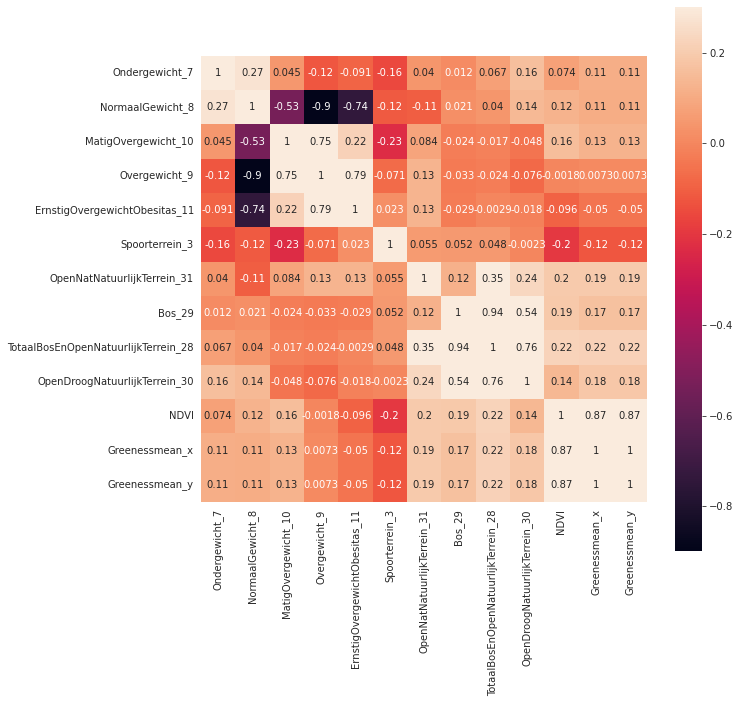

In [90]:
corrMatrix= obesitas_df.corr()

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corrMatrix, annot=True, vmax=.3, square=True)